# Análisis de sentimientos de los conflictos sociales asociados a la actividad minera en el Perú: 2007-2019
<b>Autor</b>: César Núñez Huamán

<b>Abstract</b>: 


## 1. Descripción del tema
Los conflictos sociales en el Perú han incrementado su frecuencia y magnitud en los últimos años, sobre todo aquellos asociados a las actividades extractivas como la minería. La información que se obtiene de los conflictos sociales provienen principalmente de noticias o de los reportes de la Defensoría del Pueblo. Si bien estos últimos muestran un detalle de las acciones mensuales que ocurren en cada uno de los conflictos, no se permite realizar un seguimiento específico a cada conflicto, sino que es un informe mensual de todos los conflictos. 

Ante ello, el procesamiento del lenguaje natural puede aportar al análisis de la información de los conflictos temporalmente e identificar los cambios en la intensidad de los mismos, lo cual puede facilitar la toma de decisiones por parte de las autoridades, sociedad civil y empresas privadas.

## 2. Justificación
La minería representa una de las actividades de mayor importancia para la economía peruana. En el 2022, el sector minería representó el 8.3% del Producto Bruto Interno (PBI), el 62.1% de las exportaciones peruanas y el 14.4% de los impuestos recaudados por concepto de impuesto a la renta.

A pesar del aporte significativo en términos económicos de la minería, los conflictos sociales asociados a dicha actividad han incrementado significativamente desde el 2005. De acuerdo con la Defensoría del Pueblo, la proporción de los conflictos asociados a la minería pasaron de representar el 20% del total de conflictos a nivel nacional en el 2005 a más del 50% en el 2022.

En ese sentido, urge contar con indicadores que permitan obtener información actualizada para la toma de decisiones y el manejo de los conflictos sociales. Así, el objetivo del presente trabajo es desarrollar un análisis de sentimiento de los conflictos sociales asociados a la minería a partir de los registros de la Defensoría del Pueblo para determinar la intensidad de los conflictos en función a las palabras que se asocian a cada uno de ellos.

## 3. Descripción del Corpus
El corpus utilizado en el presente trabajo corresponde a una base de datos de los conflictos sociales asociados a la minería registrados como nuevos entre enero de 2007 y diciembre de 2019. Esta base de datos fue recopilada mediante extracción de datos de los reportes de la Defensoría del Pueblo para una consultoría privada realizada en el 2021, por lo que la base de datos está actualizada con información hasta el 2020. 

La unidad de análisis de la base de datos es el conflicto social y cuenta con la siguiente información:
- Fechas de ingreso, salida y cambio de estado del conflicto.
- Descripción del conflicto.
- Ubicación del conflicto.
- Actores involucrados.
- Tipo de minería asociada al conflicto (legal o ilegal).
- Motivo de los conflictos.
- Expresiones y acontecimientos identificados durante el conflicto.

En resumen, se cuenta con información de 318 conflictos sociales que cuentan con 1,269 expresiones registradas durante el periodo de actividad de los conflictos. Es decir, la base de datos cuenta con un promedio de 4 expresiones durante su periodo de actividad.

## 4. Plan de análisis
La presente sección plantea la estrategia de análisis del corpus descrito en la sección 3. A continuación se describen las actividades a desarrollarse mediante el procesamiento de lenguaje natural:
- <b>Etapa 1</b>: Manejo de la base de datos, tokenización y vocabulario de términos.
- <b>Etapa 2</b>: Análisis de sentimiento utilizando diccionarios
- <b>Etapa 3</b>: Análisis de sentimiento utilizando VADER
- <b>Etapa 4</b>: Análisis de sentimiento utilizando modelos entrenados
- <b>Etapa 5</b>: Comparación de resultados de la etapa 3 y 4

## 5. Análisis de texto

### Etapa 1: Manejo de la base de datos, tokenización y vocabulario de términos.

In [1]:
# Importacion de librerías a utilizar
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import nltk
from nltk.corpus import stopwords
import time
import datetime
from googletrans import Translator, constants

In [2]:
# Importamos la base de datos
df = pd.read_excel('bdConflictosMineros.xlsx')

# Eliminamos tres observaciones missings
df = df.iloc[:-3,:]

# Generamos una base de datos únicamente con la descripción general de los conflictos 
dfConflictos = df.iloc[:,0:3]

# Generamos una base de datos únicamente con los cambios de estado de conflicto
filtroEstado = [col for col in df.columns if col.startswith('d_TC') or col == 'id']
dfEstadoConflicto = df[filtroEstado]

# Generamos una base de datos únicamente con los actores involucrados
filtroActor = [col for col in df.columns if col.startswith('Actor') or col == 'id' ]
dfActores = df[filtroActor]

# Generamos una base de datos únicamente con las expresiones mensuales
# Aquí debí generar dos bases intermedias dfExpresiones1 y dfExpresiones2 para luego hacer un pd.melt en cada uno
filtroDateExpresiones = [col for col in df.columns if col.startswith('d_Expresión') or col == 'id']
dfExpresiones1 = df[filtroDateExpresiones]
filtroInfoExpresiones = [col for col in df.columns if col.startswith('InfoExpresión') or col == 'id']
dfExpresiones2 = df[filtroInfoExpresiones]

# Aquí hacemos una transformación de la data de wide a long con el uso de melt
dfExpresiones1 = pd.melt(dfExpresiones1, id_vars= ['id'], var_name='dateExpresión', value_name='d_Expresión').reset_index()
dfExpresiones2 = pd.melt(dfExpresiones2, id_vars= ['id'], var_name='infoExpresión', value_name='InfoExpresión').reset_index()

# Unimos la data y nos quedamos con las variables necesarias y eliminamos missings
dfExpresiones = pd.merge(dfExpresiones1, dfExpresiones2, on=['index','id'])
dfExpresiones = dfExpresiones.loc[:,['id','d_Expresión','InfoExpresión']]
dfExpresiones = dfExpresiones[dfExpresiones['InfoExpresión'].notna()]
dfExpresiones = dfExpresiones.reset_index().iloc[:,1:]

# Eliminamos variables intermedias
del dfExpresiones1, dfExpresiones2, filtroInfoExpresiones, filtroDateExpresiones, filtroActor, filtroEstado

In [3]:
def cleanPunctNotHyphen(doc):
    return re.sub(r'[",",".",":",";","'",'"',"(",")"]','', doc)

def tokenize(doc):
    return doc.split()

def lowerCase(list):
    return [word.lower() for word in list]

def stopWords(list):
    stop= stopwords.words("spanish")
    return [word for word in list if word not in stop]
    
def cleanUpSteps(doc):
    return stopWords(lowerCase(tokenize(cleanPunctNotHyphen(doc))))


In [4]:
def makeTFDictionary(cleanDoc):
    docTermDictionary = {}
    for word in cleanDoc:
        if word in docTermDictionary.keys():
            docTermDictionary[word] += 1
        else:
            docTermDictionary[word] = 1
    return docTermDictionary

In [5]:
docTermDictionary = {}
for i, obs in enumerate(dfExpresiones['InfoExpresión']):
    cleanObs = cleanUpSteps(obs)
    for word in cleanObs:
        if word in docTermDictionary.keys():
            docTermDictionary[word] += 1
        else:
            docTermDictionary[word] = 1

del obs, cleanObs, word, i
docTermDictionary

{'comuneros': 78,
 'realizaron': 48,
 'dos': 54,
 'asambleas': 2,
 '18': 22,
 'julio': 41,
 '10': 33,
 'agosto': 47,
 'invitando': 2,
 'representante': 52,
 'empresa': 894,
 'primera': 29,
 'reunión': 502,
 'segunda': 23,
 'asamblea': 62,
 'presentó': 24,
 'ser': 30,
 'invitado': 2,
 'indican': 7,
 'hechos': 35,
 'representantes': 384,
 'comunidad': 525,
 'emplazaron': 1,
 'cumplimiento': 43,
 'acuerdos': 142,
 'retiro': 38,
 'total': 13,
 'distrito': 237,
 'pampa': 6,
 'enfrentamiento': 44,
 'trabajadores': 38,
 'consorcio': 11,
 'minero': 111,
 'operaciones': 40,
 'conexas': 7,
 'sac': 104,
 'aproximadamente': 33,
 'quince': 6,
 'pobladores': 209,
 'caserío': 46,
 'realizar': 79,
 'trabajos': 49,
 'rehabilitación': 2,
 'canal': 13,
 'regadío': 2,
 'junto': 10,
 'rio': 9,
 'alejados': 1,
 'violentamente': 3,
 'disparos': 2,
 'poblador': 6,
 'resultó': 3,
 'herido': 9,
 'levemente': 1,
 'denunció': 6,
 'presuntos': 3,
 'agresores': 1,
 'habiéndose': 6,
 'iniciado': 22,
 'investigación'

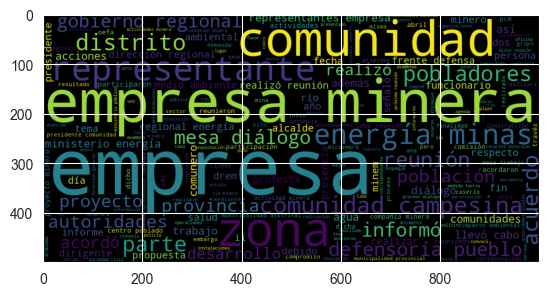

In [6]:
listTerms = []
for obs in dfExpresiones['InfoExpresión']:
    for word in cleanUpSteps(obs):
        listTerms.append(word) 

unique_string=(" ").join(listTerms)

wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.imshow(wordcloud)

del unique_string, wordcloud, word, obs, listTerms

### Etapa 2: Análisis de sentimiento utilizando diccionarios

In [7]:
def readInSentimentList(loc="./negative-words.txt", commentCharacter=";"):
    with open(file=loc, mode="r", encoding='ISO-8859-1') as f:
        temp = f.readlines()
    out = [ii.strip() for ii in temp if ii[0] != commentCharacter and ii[0] !="\n"]
    return out

In [8]:
negList = readInSentimentList()
posList = readInSentimentList(loc="./positive-words.txt")

In [9]:
def analisis_de_sentimientos(texto, positivo, negativo):
    # Convertir el texto en una lista de palabras.
    texto=texto.lower()
    palabras = texto.split()

    # Contar el número de palabras positivas, negativas y neutras.
    contador_positivo = 0
    contador_negativo = 0
    contador_neutro = 0
    for palabra in palabras:
        if palabra in positivo:
            contador_positivo += 1
        elif palabra in negativo:
            contador_negativo += 1
        else:
            contador_neutro += 1

    # Calcular las proporciones de palabras positivas, negativas y neutras.
    prop_positiva = contador_positivo / len(palabras)
    prop_negativa = contador_negativo / len(palabras)
    prop_neutra = contador_neutro / len(palabras)

    # Devolver las proporciones.
    return prop_positiva, prop_negativa, prop_neutra

In [12]:
def translate_text(text, target_language='en'):
    translator = Translator()
    try:
        translation = translator.translate(text, dest=target_language)
        if translation:
            return translation.text
        else:
            print("Error: Translation is None.")
    except Exception as e:
        print(f"Error: {e}")

translation = translate_text(dfExpresiones['InfoExpresión'][33], target_language='en')

In [13]:
prop_positiva, prop_negativa, prop_neutra = analisis_de_sentimientos(translation, posList, negList)

print(f"Proporción positiva: {prop_positiva:.2f}")
print(f"Proporción negativa: {prop_negativa:.2f}")
print(f"Proporción neutra: {prop_neutra:.2f}")

Proporción positiva: 0.03
Proporción negativa: 0.00
Proporción neutra: 0.97


### Etapa 3: Análisis de sentimiento utilizando VADER

### Etapa 4: Análisis de sentimiento utilizando modelos entrenados

### Etapa 5: Comparación de resultados de la etapa 3 y 4

## 6. Conclusiones